In [1]:
## Importing needed modules
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import graphviz
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold


<AxesSubplot:>

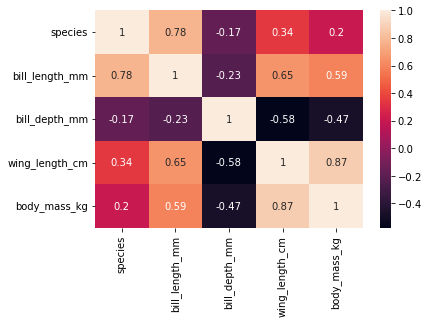

In [2]:
## Loading the puffin data

puffinData = pd.read_csv("puffins.csv")

## Dropping any rows with Nas present
## Dropping the columns 'measurement_year' and 'sex'
puffinData.dropna(inplace=True)
del puffinData["sex"]
del puffinData["measurement_year"]

## Changing the values within the table to numerical
## atlantic = 1
## horned = 2
## tufted = 3
puffinData['species'] = puffinData['species'].replace(['atlantic'],1)
puffinData['species'] = puffinData['species'].replace(['horned'],2)
puffinData['species'] = puffinData['species'].replace(['tufted'],3)

## Making the relevent x and y data subsets
puffinData_X = puffinData[['bill_length_mm',  'bill_depth_mm',  'wing_length_cm',  'body_mass_kg']]
puffinData_Y = puffinData['species']

## Firstly visualizing the data, to see what the likely key component interactions are
import seaborn as sns
sns.heatmap(puffinData.corr(), annot=True)


In [3]:
## Training the classifier for KNN
train_X, test_X, train_y, test_y = train_test_split(puffinData_X,puffinData_Y, random_state=42,test_size = 0.35,stratify = puffinData['species'])

Score for K-Neighbors Classifier is: 0.991
From PCA analysis, the best estimator is: 3


Text(0.5, 1.0, 'Confusion Matrix KNC')

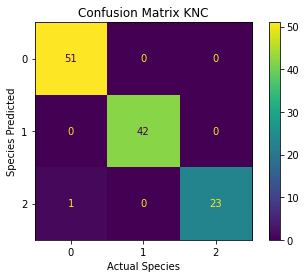

In [4]:
## K-Neighbors Classifier

## Overall pipeline, with PCA
KNC_Pipeline = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        KNeighborsClassifier(n_neighbors=5)
    ),
    {
        "pca__n_components" : range(1, 4),
    }
)

## Fitting the model and viewing the score
KNC_Pipeline.fit(train_X, train_y)
print(f"Score for K-Neighbors Classifier is: {KNC_Pipeline.score(test_X, test_y):.3}")
print(f"From PCA analysis, the best estimator is: {KNC_Pipeline.best_estimator_['pca'].n_components_}")

## Confusion matrix for KNC, shows all but one sample were correct

## Predicting the values 
y_PredictionKNC = KNC_Pipeline.predict(test_X)

## Making the matrix
confusionMatrixKNC = confusion_matrix(test_y, y_PredictionKNC)
confusionMatrixKNCDisplay = ConfusionMatrixDisplay(confusionMatrixKNC).plot()
plt.xlabel("Actual Species")
plt.ylabel("Species Predicted")
plt.title("Confusion Matrix KNC")


Score for Decision Tree Classifier Classifier is: 0.949


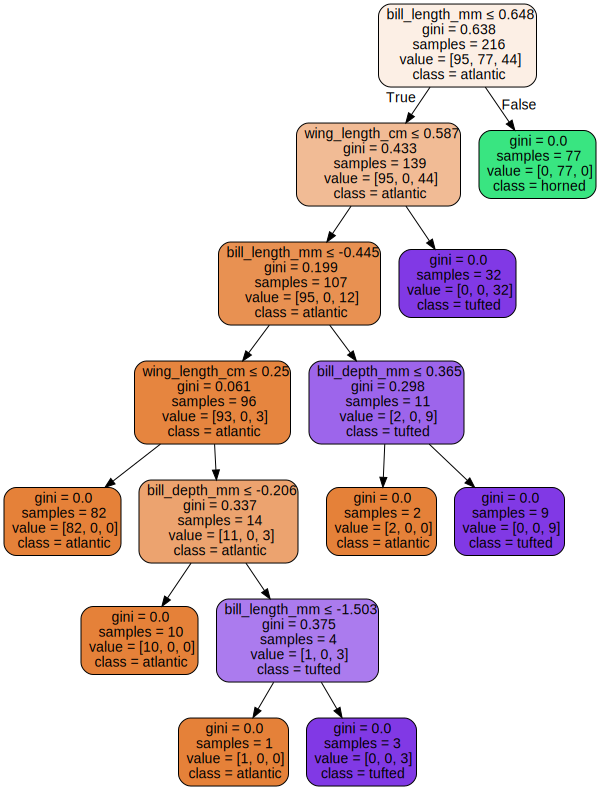

In [5]:
## Decision Tree Classifier

## Making the pipeline
DTC_Pipeline = make_pipeline(
        StandardScaler(),
        PCA(4),
        tree.DecisionTreeClassifier(random_state = 42)
)
## Fitting the model
DTC_Pipeline.fit(train_X, train_y)
print(f"Score for Decision Tree Classifier Classifier is: {DTC_Pipeline.score(test_X, test_y):.3}")

## Enhancing the graphics so it is easier to interpret
dot_data = tree.export_graphviz(DTC_Pipeline[2], out_file=None, 
                    feature_names=['bill_length_mm','bill_depth_mm','wing_length_cm','body_mass_kg'],
                    class_names=['atlantic','horned','tufted'],
                    filled=True, rounded=True,  
                    special_characters=True
                    )

## Applying the graphics
graph = graphviz.Source(dot_data)  

## Outputting the tree
graph




Text(0, 0.5, 'Species Predicted')

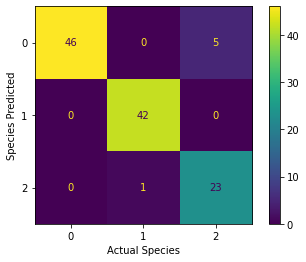

In [6]:
## Confusion matrix for DTC

## Confusion matrix for KNC, showed six incorrectly identified species

## Predicting the values 
y_pred = DTC_Pipeline.predict(test_X)

## Making the matrix
cm = confusion_matrix(test_y, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.xlabel("Actual Species")
plt.ylabel("Species Predicted")

In [7]:
## Calculating the feature importance 
importance = DTC_Pipeline[2].feature_importances_

for i,v in enumerate(importance):
	print(f"Importance of feature: {['bill_length_mm',  'bill_depth_mm',  'wing_length_cm',  'body_mass_kg'][i]}\n		is score: {v:.3}")

## Interestingly, this shows that bill_length_mm is the most prominant feature within the set


Importance of feature: bill_length_mm
		is score: 0.663
Importance of feature: bill_depth_mm
		is score: 0.0471
Importance of feature: wing_length_cm
		is score: 0.29
Importance of feature: body_mass_kg
		is score: 0.0


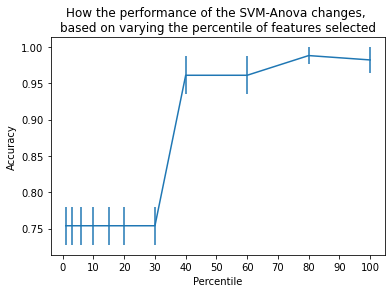

In [8]:
## SVC

## Checking to see how many features should be kept

SVC_CheckPipeline = Pipeline(
    [
        ("anova", SelectPercentile(chi2)),
        ("scaler", StandardScaler()),
        ("svc", SVC(gamma="auto",random_state = 42,decision_function_shape='ovr',kernel="linear"),),
    ]
)
scoremeans = list()
scoreSTDs = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

## Looping over each percentile and checking the accuracy
for percentile in percentiles:
    SVC_CheckPipeline.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(SVC_CheckPipeline, puffinData_X, puffinData_Y)
    scoremeans.append(this_scores.mean())
    scoreSTDs.append(this_scores.std())

## Outputting the accuracies as a graph
plt.errorbar(percentiles, scoremeans, np.array(scoreSTDs))
plt.title("How the performance of the SVM-Anova changes, \nbased on varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy")
plt.axis("tight")
plt.show()



Score for SVC Classifier is: 0.991
From PCA analysis, the best estimator is: 3


Text(0, 0.5, 'Species Predicted')

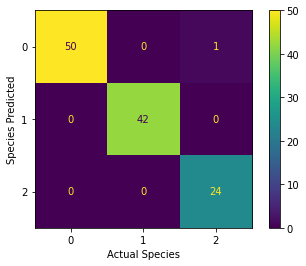

In [9]:
## Taking 80% of features, as this was the highest accuracy based on the graph made in the previous step
## Also re-making puffinData_X and puffinData_Y to incorporate this change
featureSelection = VarianceThreshold(0.8)
featureSelection.fit_transform(puffinData)

puffinData_X = puffinData[['bill_length_mm',  'bill_depth_mm',  'wing_length_cm',  'body_mass_kg']]
puffinData_Y = puffinData['species']


train_X, test_X, train_y, test_y = train_test_split(puffinData_X,puffinData_Y, random_state=42, test_size = 0.35,stratify = puffinData['species'])


SVC_Pipeline = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        SVC(gamma=0.1,random_state = 42,decision_function_shape='ovr',kernel="linear",tol=0.8,C=0.5),
    ),
    {
        "pca__n_components" : range(1, 4),
    }
)


SVC_Pipeline.fit(train_X, train_y)
print(f"Score for SVC Classifier is: {SVC_Pipeline.score(test_X, test_y):.3}")
print(f"From PCA analysis, the best estimator is: {SVC_Pipeline.best_estimator_['pca'].n_components_}")

## Checking what species were correct and incorrect with a confusion matrix shows only one wrong prediction
y_Prediction = SVC_Pipeline.predict(test_X)
confusionMatrix_SVC = confusion_matrix(test_y, y_Prediction)
cm_display = ConfusionMatrixDisplay(confusionMatrix_SVC).plot()
plt.xlabel("Actual Species")
plt.ylabel("Species Predicted")

In [10]:
## Taking the results from 3 and making a simpler pipeline, for potential use in Prediction.py

SVC_PipelineSimple = make_pipeline(
        StandardScaler(),
        PCA(3),
        SVC(gamma=0.1,random_state = 42,decision_function_shape='ovr',kernel="linear",tol=0.8,C=0.5),
    )

SVC_PipelineSimple.fit(train_X, train_y)

## Checking score is the same
try:
    assert {SVC_PipelineSimple.score(test_X, test_y):.3} == {SVC_Pipeline.score(test_X, test_y):.3}
    print("Scores identical, as expected!\n"
        f"Score for SVC Classifier without GridSearchCV is: {SVC_PipelineSimple.score(test_X, test_y):.3}\n"
        f"Score for SVC Classifier with GridSearchCV is: {SVC_Pipeline.score(test_X, test_y):.3}"
    )
except:
    print("Error, score values different. Have you changed random_state, or PCA numbers?\n"
        f"Score for SVC Classifier without GridSearchCV is: {SVC_PipelineSimple.score(test_X, test_y):.3}\n"
        f"Score for SVC Classifier with GridSearchCV is: {SVC_Pipeline.score(test_X, test_y):.3}"
    )



Scores identical, as expected!
Score for SVC Classifier without GridSearchCV is: 0.991
Score for SVC Classifier with GridSearchCV is: 0.991


In [11]:
## Comparing all scores, shows DTC to be the worst, with KNN and SVC bering identical
print(
    f"Score for K-Neighbors Classifier is: {KNC_Pipeline.score(test_X, test_y):.3}"
    f"\nScore for Decision Tree Classifier Classifier is: {DTC_Pipeline.score(test_X, test_y):.3}"
    f"\nScore for SVC Classifier is: {SVC_Pipeline.score(test_X, test_y):.3}"
)

Score for K-Neighbors Classifier is: 0.991
Score for Decision Tree Classifier Classifier is: 0.949
Score for SVC Classifier is: 0.991


## Predicting a new data point
A separate script is present called <code>Prediction.py</code>, which takes either user input or analyses a file placed within <code>Data_To_Analyse</code>. Outputted results can then be viewed or saved to <code>Output_Prediction</code>.

## Write up

I choose to design three classifiers, and then choose the best of the three. The three I designed were <a style="color:blue">KNN</a>, <a style="color:red">DTC</a>, and <a style="color:purple">SVC</a>. <a style="color:blue">KNN</a> had a score of <b style="color:blue">0.991</b>, <a style="color:red">DTC</a> had a score of <b style="color:red">0.949</b>, and <a style="color:purple">SVC</a> had a score of <b style="color:purple">0.991</b>. Of these, KNN and SVC both showed to have an identical prediction success rate, however I choose to go with KNN. I choose KNN as a <a href = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6082635/">study</a> found KNN to be able to identify more patterns then that of SVC, however this trade-off comes as KNN is more difficult to interpret. Since the data set provided was relatively small, computational demands and worry of accuracy deterioration at higher feature count was negligible. Had the data set have been bigger with more features, or with more features but a similar size training set, then SVC would have likely out-performed KNN. Taking the results of the KNN model generated, I wrote a script called <code>Prediction.py</code>, which is able to predict the species of a bird, if provided with: <code>['bill_length_mm',  'bill_depth_mm',  'wing_length_cm',  'body_mass_kg']</code>. To visualize the results of the classifiers I choose to go with confusion matrices, as these are a good representation of how well a classifier worked. They will highlight and total any wrong predictions, making it easy to see how many were incorrect. For both KNN and SVC, only one incorrect answer can be seen. However, with the DTC classifier 6 mistakes can be seen.

